# Welcome to Vector CV Tools

The ultimate goal of our current tooling is to be able to provide useful out of the box PyTorch compatible dataloaders that can work efficiently on the cluster. I will now demo how the image datasets COCO, Cityscapes and MVTEC AD dataset can work out of the box with our tooling

## Code set up

In [8]:
COCO_VAL_PATH = "./datasets/MSCOCO2017/val2017"
COCO_VAL_ANNS = "./datasets/MSCOCO2017/annotations/instances_val2017.json"
COCO_VAL_KP_ANNS = "./datasets/MSCOCO2017/annotations/person_keypoints_val2017.json"
MVTEC_ROOT_DIR = "./datasets/MVTec_AD"
CITYSCAPES_ROOT_DIR = "./datasets/cityscapes/cityscapes/cityscapes_dataset"

In [66]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from albumentations.pytorch import ToTensorV2 # this allows the transform to output a PyTorch Tensor
import albumentations as A
from torch.utils.data import DataLoader
from vector_cv_tools import utils as vutils
from vector_cv_tools import datasets as vdatasets
from vector_cv_tools import transforms as VT
from skimage.color import label2rgb
%matplotlib inline

In [10]:
def to_loader(dset, batch_size = 32):
    # note that this collate fn is needed for all our image datasets
    # as the PyTorch default WILL load the data in the wrong ordering
    return DataLoader(dset, collate_fn=vutils.collate_dictionary_fn, batch_size=batch_size)

In [11]:
def plot_mask_bbox(img, mask, bbox, label_name):
    figure, ax = plt.subplots(1, 3, figsize=(10, 10))
    bboxed_image = vutils.plot_bbox(img.copy(),bbox, label_name)
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].set_title(f"Mask {label_name}")
    ax[1].imshow(mask)
    ax[2].set_title(f"Bounding Box {label_name}")
    ax[2].imshow(bboxed_image)
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
def plot_kp_img(img, keypoints):
    figure, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].set_axis_off()
    img_kps = img.copy()
    for (x, y) in keypoints:
        cv2.circle(img_kps, (int(x), int(y)), 3, (255,0,0), -1)
    ax[1].imshow(img_kps)
    ax[1].set_title("Image with KPs")
    ax[1].set_axis_off()

## COCO Dataset

Our dataloaders are capable of loading keypoints, segmentation masks and bounding boxes from the dataset. There are 2 classes in our tooling for COCO: CocoDetection which is used to load masks and bounding boxes and COCO Keypoints which loads masks, bounding boxes and keypoints as well. COCO support is provided for train and val for instances, stuff and keypoints annotations.

In [12]:
# define the dataset
coco_dset = vdatasets.CocoDetection(COCO_VAL_PATH, COCO_VAL_ANNS)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


### Showing the first sample

In [13]:
img, target = coco_dset[2]
target.keys() # this is why we need that collate dictionary function

dict_keys(['masks', 'boxes', 'labels', 'label_names'])

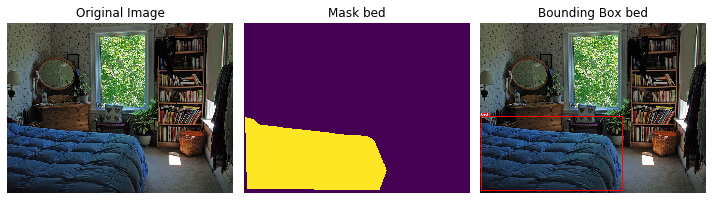

In [14]:
mask = target['masks'][0]
bbox = target['boxes'][0]
label_name = target["label_names"][0]
plot_mask_bbox(img, mask, bbox, label_name)

### COCO Data Augmentation

For our image datasets, we've decided to provide extensive support for the https://albumentations.ai framework. Essentially all you need to do is to make sure you pass in a list of albumentations transforms to our compose functions. The good thing about using this frame is that it will apply the transformations we specify on masks, bounding boxes and key points out of the box. All our composed transformations for images are callable classes that take img and target as input

In [15]:
coco_transforms = VT.ComposeCOCOTransform([A.RandomRotate90(p=1)])
coco_aug_dset = vdatasets.CocoDetection(COCO_VAL_PATH, COCO_VAL_ANNS, transforms = coco_transforms)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


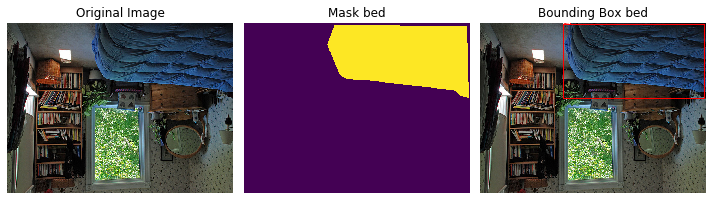

In [16]:
aug_img, target = coco_aug_dset[2]
aug_mask = target['masks'][0]
aug_bbox = target['boxes'][0]
aug_label_name = target["label_names"][0]
plot_mask_bbox(aug_img, aug_mask, aug_bbox, aug_label_name)

## COCO KeyPoints

We also have support for the COCO keypoints annotations, currently COCO only has keypoints annotated for pictures containing people

In [17]:
coco_kps = vdatasets.CocoKeypoints(COCO_VAL_PATH,COCO_VAL_KP_ANNS)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


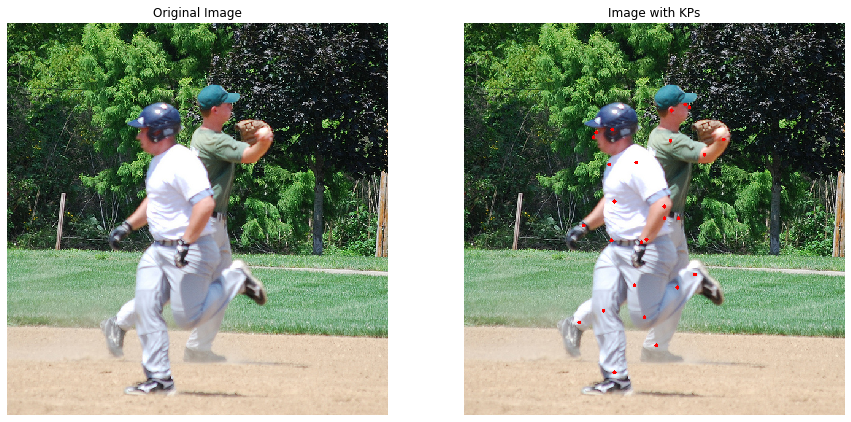

In [18]:
aug_img, target = coco_kps[2]
plot_kp_img(aug_img, target["keypoints"])

## Cityscapes 

Our implemented dataloaders are capable of loading all targets types of the cityscapes dataset that have the fine annotation as those are the ones downloaded on the cluster.

In [19]:
def get_multi_label_mask_to_plot(img, mask):
    return label2rgb(mask, img.copy(), bg_label=0, bg_color=None)

#visualizes color, instance and semantic masks
def visualize_cityscapes(img, target):
    figure, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].set_title("Color Mask")
    ax[1].imshow(target["color"])
    ax[2].set_title("Instance Mask")
    ax[2].imshow(get_multi_label_mask_to_plot(img, target["instance"]))
    ax[3].set_title("Semantic Mask")
    ax[3].imshow(get_multi_label_mask_to_plot(img, target["semantic"]))
    for i in range(4):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

def visualize_binary_masks(img, list_of_masks, labels):
    figure, ax = plt.subplots(1, len(list_of_masks), figsize=(23, 23))
    for i, mask in enumerate(list_of_masks):
        ax[i].imshow(mask)
        ax[i].set_title(labels[i])
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Our tooling also provides out of the box support for the Cityscapes dataset for color, semantic, instance and polygon(which are converted to masks in our transforms pipeline). The difference between semantic and instance masks is that semantic masks are provided such that each pixel belongs to a class, whereas the instance masks group each individual instance. Lets take a look below!

In [20]:
cityscapes_dset = vdatasets.Cityscapes(CITYSCAPES_ROOT_DIR, split="train", target_type=["color", "semantic", "instance", "polygon"], load_license_plates=True)
img, target = cityscapes_dset[1]
print(target.keys()) # again the target is still a dictionary(so in the loader one has to use utils.collate_dictionary_fn we provide)
print(target["polygon"].keys())

dict_keys(['color', 'semantic', 'instance', 'polygon'])
dict_keys(['imgHeight', 'imgWidth', 'polygons', 'label_ids', 'label_names'])


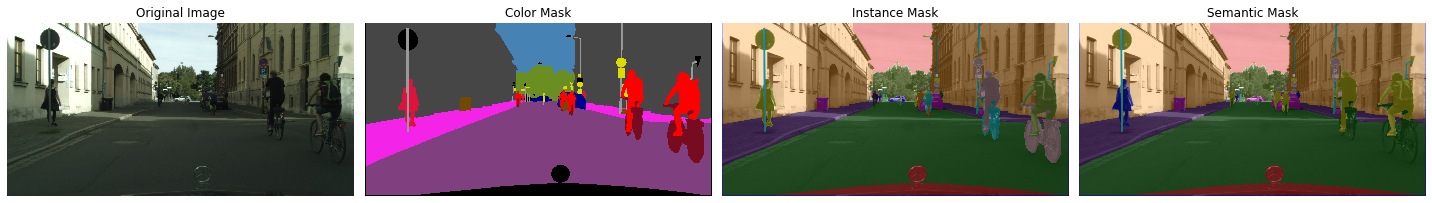

In [21]:
# for all keys but polygon, target[type] will give a mask
visualize_cityscapes(img, target) 

Notice how the 2 people are annotated with the same colour in the semantic mask since it's a pixel wise label compared to the instance mask

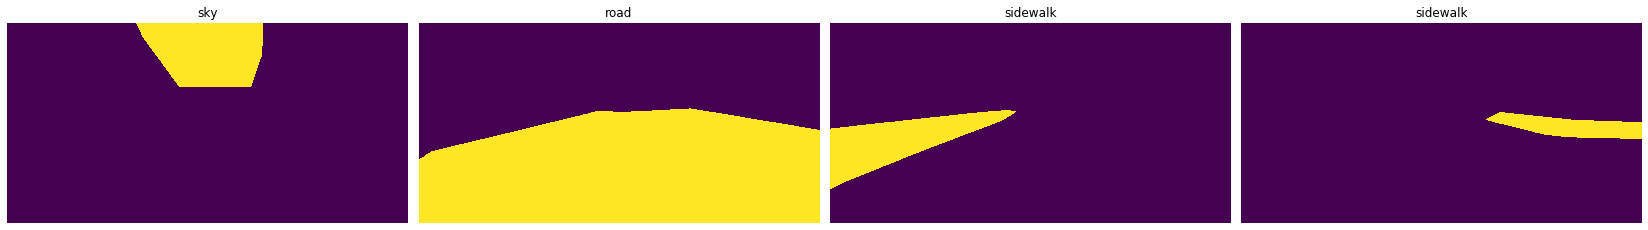

In [22]:
list_of_masks = [vutils.polygon_to_mask(x, target['polygon']['imgHeight'], target['polygon']['imgWidth']) for x in target["polygon"]["polygons"][:4]]
label_names = target["polygon"]["label_names"][:4]
visualize_binary_masks(img, list_of_masks, label_names)

### Cityscapes Data Augmentation

In [23]:
cityscapes_transform = VT.ComposeCityscapesTransform([A.Resize(480,480), A.ShiftScaleRotate(p=1)])

In [24]:
cityscapes_aug_dset = vdatasets.Cityscapes(CITYSCAPES_ROOT_DIR, split="train", target_type=["color", "semantic", "instance", "polygon"], load_license_plates=True, transforms = cityscapes_transform)
aug_image, target = cityscapes_aug_dset[1]
print(target.keys()) # again the target is still a dictionary(so in the loader one has to use utils.collate_dictionary_fn we provide)

dict_keys(['color', 'semantic', 'instance', 'polygon'])


In [25]:
print(target["polygon"].keys())

dict_keys(['label_ids', 'label_names', 'masks'])


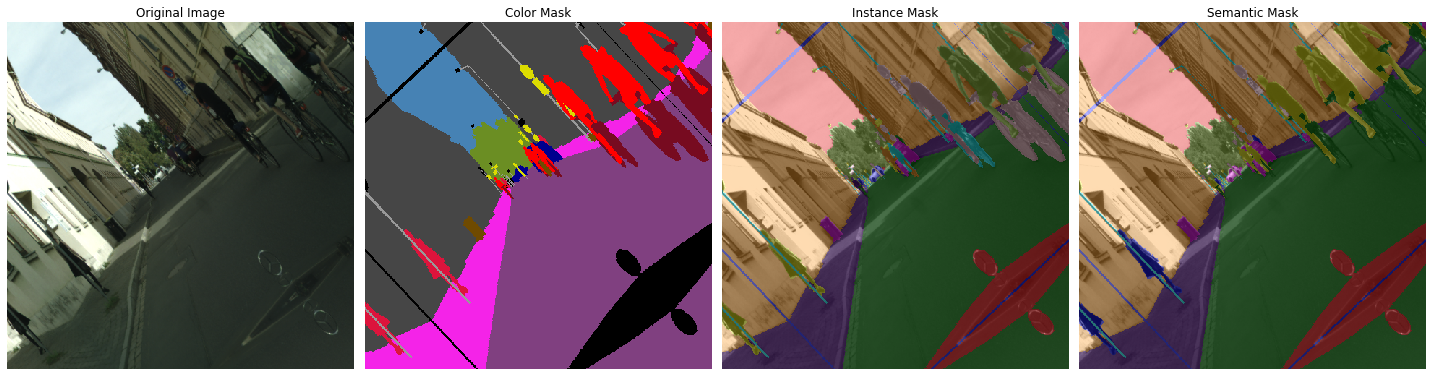

In [26]:
target["color"] = target["color"].permute(1,2,0).numpy()
target["semantic"] = target["semantic"].numpy()
target["instance"] = target["instance"].numpy()
visualize_cityscapes(aug_image, target)

#### Handling of Polygons in our data pipeline

One thing to note about the way we implemented the cityscapes polygons is that our compose function will first **write the polygons to a mask**  and then perform data augmentations on the mask. This ensures that our framework is easy to use and allows this to follow the albumentations pipeline we have, however does come with a memory cost. If you specify "polygons" in the target type, make sure to set higher memory and lower number of workers as they are memory intensive when using our provided transform

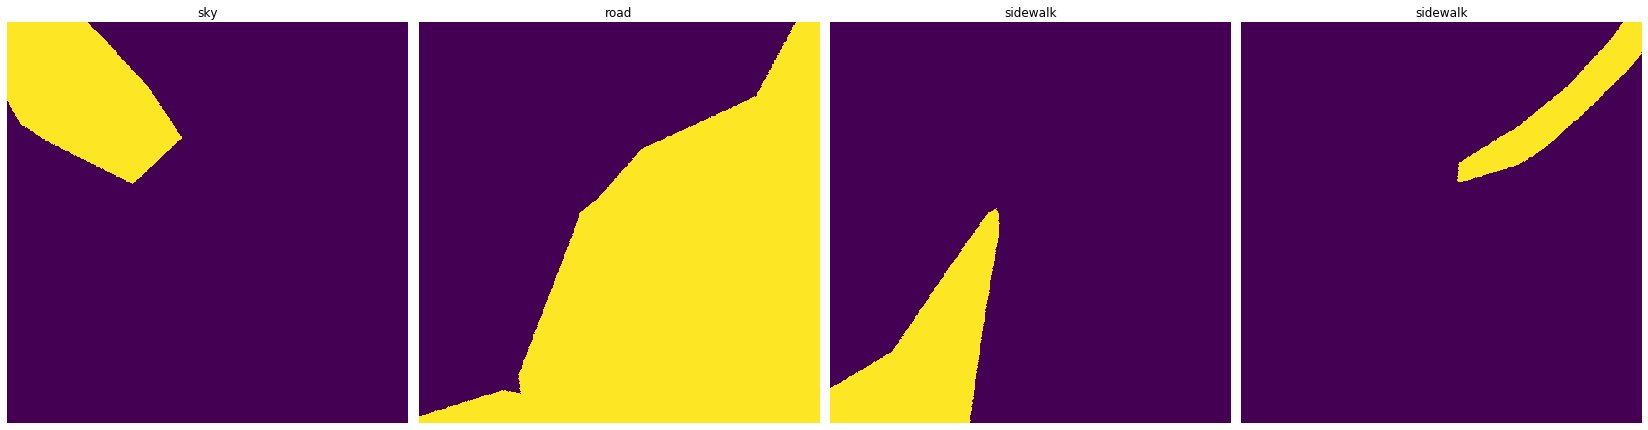

In [27]:
list_of_masks = target["polygon"]["masks"][:4]
label_names = target["polygon"]["label_names"][:4]
visualize_binary_masks(img, list_of_masks, label_names)

# MVTec AD

The MVTec dataset is generally used as a tool for anomaly detection in images. The train set consists of 3629 normal images composed of many different object types, and test set consists of 1258 abnormal images with mask available and 467 normal images.

In [28]:
def visualize_mvtec(img, mask):
    figure, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img)
    ax[0].set_axis_off()
    ax[1].imshow(mask)
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

Notice that an empty mask will result in the mask key being None

{'label_names': ('hazelnut', 'good'), 'label_ids': (5, 0), 'mask': None}


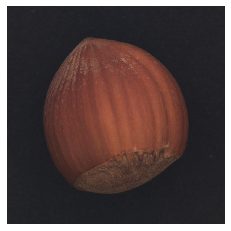

In [29]:
mvtec_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="train")
img, target = mvtec_dset[1234]
print(target)
plt.imshow(img)
plt.axis("off")
plt.show()

dict_keys(['label_names', 'label_ids', 'mask'])


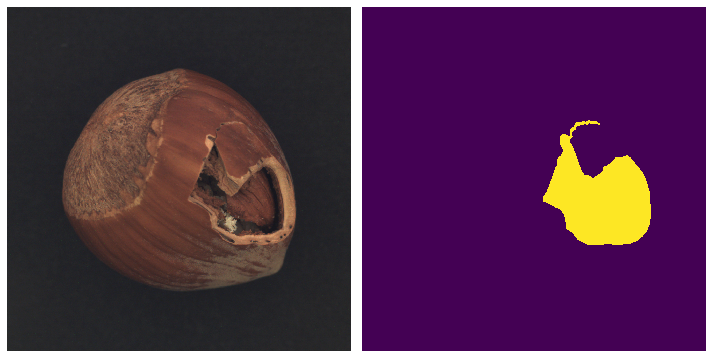

In [30]:
anomaly_mvtec = vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", mask_only=True, obj_types=["hazelnut"])
img, target = anomaly_mvtec[1]
print(target.keys())
visualize_mvtec(img, target['mask'])

### MVTec Data Augmentation

dict_keys(['label_names', 'label_ids', 'mask'])


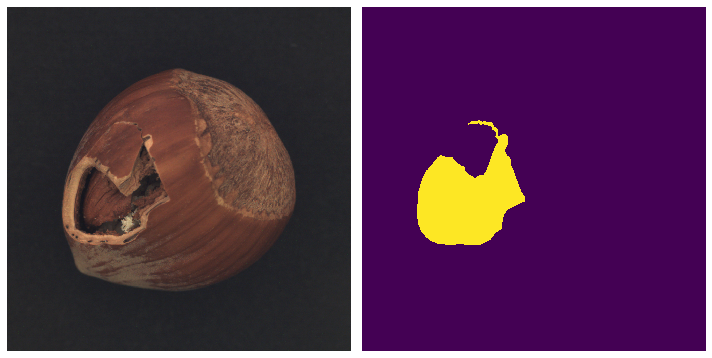

In [31]:
mvtec_transform = VT.ComposeMVTecTransform([A.HorizontalFlip(p=1)])
anomaly_mvtec_transformed = vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", mask_only= True ,obj_types=["hazelnut"],transforms = mvtec_transform)
img, target = anomaly_mvtec_transformed[1]
print(target.keys())
visualize_mvtec(img, target['mask'])

# Training a generative model to detect anomalies

One naive approach of detecting anomalies without labels is to train a generative model, such as an autoencoder, GAN, flow-based models and VAEs. The intutition is as follows: I train my generative model on normal images, and then task it to try and reconstruct abnormal ones. Since the model did not see the abnormal images during training, it should fail to reconstruct it (but does this always happen?). I will demonstrate how well a VAE trained on normal images in MVTec can/cannot allow for anomaly detection.

## Step 1. Train the model or rather, use a pre-trained one

In [67]:
from model import ConvVAE, loss_fn

In [68]:
def show_img_from_tensor(single_img):
    single_img = single_img.permute(1,2,0).cpu().numpy()
    plt.imshow(single_img)
    plt.axis("off")
    plt.show()
    
def evaluate_and_show(model, single_input):
    single_input = single_input.to("cuda")
    with torch.no_grad():
        recon, mu, logvar = model(single_input)
    loss = loss_fn(single_input, recon, mu , logvar)
    print("Loss is: ", loss.item())
    show_img_from_tensor(recon.squeeze(0))

In [69]:
model = ConvVAE().to("cuda")
model.load_state_dict(torch.load("/checkpoint/gshensvm/cv_models_updated/model_500.pt")["model"])
model.eval()
print(model)

ConvVAE(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [70]:
basic_transform = VT.ComposeMVTecTransform([A.Resize(128, 128), A.ToFloat(max_value=255), ToTensorV2()])
test_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", mask_only= True ,obj_types=["toothbrush"], transforms = basic_transform)
train_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="train", transforms = basic_transform, obj_types=["toothbrush"])

In [71]:
sample_train_img, sample_train_target = train_dset[30]

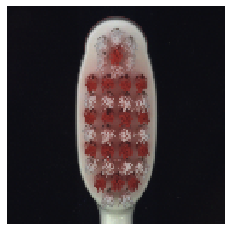

In [72]:
show_img_from_tensor(sample_train_img)

Loss is:  80.73849487304688


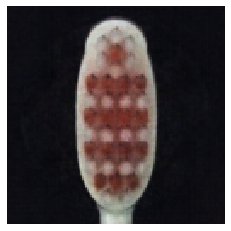

In [73]:
evaluate_and_show(model, sample_train_img.unsqueeze(0))

In [74]:
sample_test_img, sample_test_target = test_dset[10]

{'label_names': ('toothbrush', 'defective'), 'label_ids': (11, 18), 'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)}


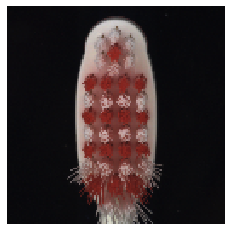

In [75]:
print(sample_test_target)
show_img_from_tensor(sample_test_img)

Loss is:  249.60009765625


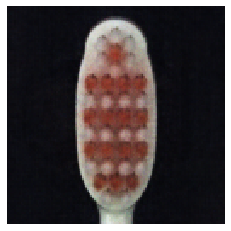

In [76]:
evaluate_and_show(model, sample_test_img.unsqueeze(0))

## What happens if we data augment the test image?

In [81]:
rotated_transform = VT.ComposeMVTecTransform([A.Resize(128, 128),A.RandomRotate90(p=1),A.ToFloat(max_value=255),ToTensorV2()])
test_dset_flipped = vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", mask_only= True ,obj_types=["toothbrush"], transforms = rotated_transform)

In [82]:
sample_test_aug_img, sample_test_aug_target = test_dset_flipped[10]

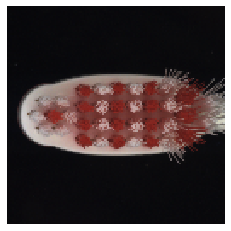

In [83]:
show_img_from_tensor(sample_test_aug_img)

Loss is:  1264.5360107421875


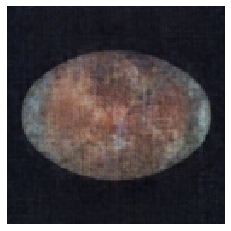

In [84]:
evaluate_and_show(model, sample_test_aug_img.unsqueeze(0))

So that wasn't good... from the preliminary results it looks like even with a dataset of anamoalies flipping the image does more damage to the model.. I would encourage the opportunity to try less naive methods than just comparing the loss and other things such as: 

* what happens we train an even bigger generative model? The current model is trained using 128x128 images so it might not capture the fine details in abnormal images
* are there other heuristics that can help the model? other training techniques like constrastive learning?
* which data augmentations do the most damage to the model's ability to reconstruct inputs?
* how much data augmentation to use during training, and their effects on model robustness
* does this happen for every object and contamination type in MVTec? Does it happen on average over the training and test sets?

The field of model robustness in images will be super interesting to try!